In [1]:
from data.utils import get_dataset
import captum
import random
import torch
import torchvision
from torchvision import transforms
import numpy as np
from captum.attr import IntegratedGradients
from DebiAN.models.simple_cls import get_simple_classifier

from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
from torchvision import models

In [2]:
?get_simple_classifier

# Functions

In [3]:
from matplotlib import cm
import numpy as np

def overlay(input, cam, alpha=0.9, colormap="jet"):
    # inspired by https://github.com/frgfm/torch-cam/blob/master/torchcam/utils.py

    img = transforms.ToPILImage()(input)
    # normalize to 0,1
    cam -= torch.min(cam)
    cam /= torch.max(cam)
    cam_img = transforms.ToPILImage(mode='F')(cam)

    if type(colormap) is str:
        cmap = cm.get_cmap(colormap)
    else:
        cmap = colormap

    # Resize mask and apply colormap
    overlay_raw = cam_img.resize(img.size, resample=Image.BILINEAR)
    overlay_raw = cam_img.resize(img.size, resample=Image.NEAREST)
    overlay = overlay_raw
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    # Overlay the image with the mask
    overlayed_img = Image.fromarray((alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8))
    return overlayed_img

# Parameters

In [4]:
fontsize = 32
viz = True
idx_img=4

# LOAD MODEL and DATA

In [5]:
model_path="DebiAN/exp/cmnist/MLP_100/debian_bs_256_wd_1E-04_lr_1E-03_cmnist_5pct/last.pth"

# Seed everything
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)

# Get dataset
test_dataset=get_dataset('cmnist',
        data_dir='data/',
        dataset_split="test",
        transform_split="valid",
        percent='1pct')

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)
#dataiter = iter(testloader)
#images, labels = dataiter.next()

# load checkpoint

model=get_simple_classifier('mlp',last_hidden_layer=100)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict['model'])
model.cpu()
model = model.eval()
print(model)


MLP(
  (feature): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
  )
  (classifier): Linear(in_features=100, out_features=10, bias=True)
)


# Prediction

In [6]:
image,label,idx = test_dataset[idx_img]
l_target,l_bias=label
l_target=l_target.item()
l_bias=l_bias.item()
correct=0
bias=0
x=torch.unsqueeze(image, 0)
image=torch.squeeze(image,0)
image.size()

torch.Size([3, 28, 28])

In [7]:
logits=model(x)
pred = logits.data.max(1, keepdim=True)[1].squeeze(1)
pred=pred.item()

if pred==l_target:
    correct=1
if l_bias==l_target:
    bias=1
if correct:
    print('Good prediction of {}'.format(pred))
else:
    print('Bad prediction of{}'.format(pred))
if bias:
    print(' with allign-bias data')
else:
     print(' with conflict-bias data')

Good prediction of 1
 with conflict-bias data


# Saliency Map

In [8]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [9]:
x.requires_grad = True

In [10]:
def attribute_image_features(net,algorithm, input,label, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=label,
                                              **kwargs
                                             )
    return tensor_attributions

In [11]:
# Saliency
saliency = Saliency(model)
grads = saliency.attribute(x, target=l_target)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [12]:
# Integrated Gradient
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(model,ig, x,l_target, baselines=x * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.1610], dtype=torch.float64)


In [13]:
# Integrated Gradient with Smoothgrad
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(model,nt,x,l_target, baselines=x * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


In [14]:
#DeepLift
dl = DeepLift(model)
attr_dl = attribute_image_features(model,dl, x,l_target,baselines=x * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/opt/conda/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [18]:
print('Original Image')
print('Predicted:', pred, 
      ' Probability:', torch.max(F.softmax(logits, 1)).item())
original_image = np.transpose((image.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

Original Image
Predicted: 1  Probability: 1.0
torch.Size([3, 28, 28])


# Visualization

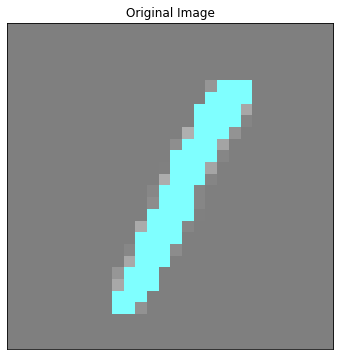

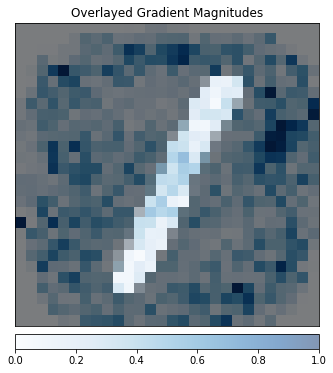

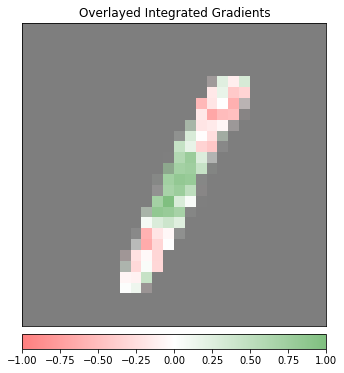

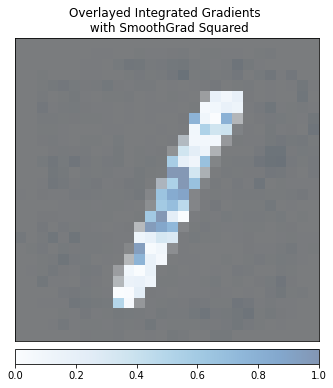

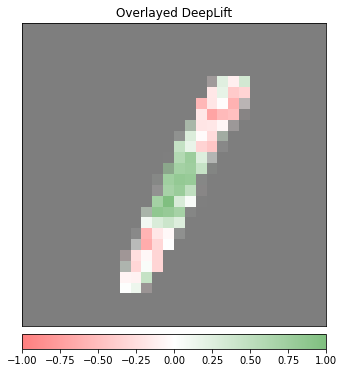

In [16]:
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

# SAVE image

In [ ]:
viz=True
plt.tight_layout()
if viz:
    #print(name, int(dataset[i][1]), imagenet_labels[int(dataset[i][1])])
    plt.show()
else:
    fig.savefig("comparison/"+model_type + "/" + name)
    fig.clear(True)